In [1]:
%config Completer.use_jedi = False

In [4]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp , routing_parameters_pb2
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from Route_Optimizer import RouteOptimizer
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668

dataset = "../datasets/UK10_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

In [5]:
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
#station_coordinates = generate_coordinates(station_data)
station_coordinates = pd.read_csv('../datasets/UK10_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "long"]].to_numpy()
points_distance_matrix = make_open_problem(squareform(pdist(points_coordinate)))

In [6]:
def create_data_model():
    data = {}
    data['distance_matrix'] = points_distance_matrix.tolist()
    data['num_vehicles'] = 2
    data['depot'] = 0
    data['demands'] = station_data.T.loc["Demand(kg)"].astype(int).to_numpy().tolist()
    data['vehicle_capacities'] = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(data['num_vehicles'])]
    return data

def get_solution(data, manager, routing, solution):
    """Prints solution on console."""
    vehicle_solutions = {}
    route_data = {"Distances":[],"Loads":[]}
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        vehicle_solutions[vehicle_id] = []
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            if index > distance_data.shape[0]-1:
                vehicle_solutions[vehicle_id].append(0)
            else:
                vehicle_solutions[vehicle_id].append(index)
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            
            previos_id = previous_index if previous_index <= 10 else 0
            idx = index if index <= 10 else 0
            route_distance += data['distance_matrix'][previos_id][idx]
            route_load += data['demands'][idx]
            

        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}kg\n'.format(route_load)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        route_data["Distances"].append(route_distance)
        route_data["Loads"].append(route_load)
    print('Maximum of the route distances: {}m'.format(max_route_distance))
    print('Sum of the route distances: {}m'.format(sum(route_data["Distances"])))
    return vehicle_solutions,route_data

In [7]:
class Optimizer_SA(RouteOptimizer):
    
    def __init__(self,data={}):
        super().__init__(data)
        
    def init_search_parameters(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.log_search = True
        search_parameters.time_limit.seconds = 1
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_INSERTION)
        search_parameters.local_search_metaheuristic =(routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
        return search_parameters

In [8]:
#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")


In [9]:
meta_data

,Customer Amount,Vehicle Curb Weight(kg),Max Load(kg),Minimum Speed(km/h),Maximum Speed(km/h)
0,10,6350,3650,20,90


In [10]:
station_data

,City Name,Demand(kg),Ready Time(sec),Due Time(sec),Service Time(sec)
0,Kingston_upon_Hull,0,0,32400,0
1,Pocklington,721,2171,22139,1442
2,Brough,814,644,21053,1628
3,Selby,620,1049,20424,1240
4,Boughton,311,5119,24241,622
5,Barton_upon_Humber,167,2338,21697,334
6,Darfield,513,3675,24120,1026
7,Bentley,568,4401,25046,1136
8,Watton,763,3485,24335,1526
9,Cudworth,558,3740,24049,1116


In [11]:
pd.DataFrame(points_distance_matrix)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.475380,2.127833,0.730425,1.431459,0.124728,1.057485,2.253264,1.653566,1.093493,0.783061
1,0.0,0.000000,1.652723,0.327769,1.857132,0.421560,0.719168,2.682894,2.102080,0.736505,0.309140
2,0.0,1.652723,0.000000,1.453269,3.425964,2.060184,1.367336,4.236647,3.702603,1.309846,1.345006
3,0.0,0.327769,1.453269,0.000000,1.977923,0.635737,0.395467,2.795690,2.249834,0.409230,0.233547
4,0.0,1.857132,3.425964,1.977923,0.000000,1.441574,2.108158,0.825774,0.317883,2.164073,2.130215
5,0.0,0.421560,2.060184,0.635737,1.441574,0.000000,0.943723,2.266997,1.681080,0.982058,0.718076
6,0.0,0.719168,1.367336,0.395467,2.108158,0.943723,0.000000,2.897941,2.403953,0.057738,0.569617
7,0.0,2.682894,4.236647,2.795690,0.825774,2.266997,2.897941,0.000000,0.631716,2.954977,2.954105
8,0.0,2.102080,3.702603,2.249834,0.317883,1.681080,2.403953,0.631716,0.000000,2.459052,2.387360
9,0.0,0.736505,1.309846,0.409230,2.164073,0.982058,0.057738,2.954977,2.459052,0.000000,0.563365


## Set up constraints

In [12]:

def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]


## Add constraints and weights. This should be turned in to functions in the future

In [13]:

"""Solve the CVRP problem."""
# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])#data['starts'],data['ends'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

dimension_name = 'Capacity'
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)

distance_dimension.SetGlobalSpanCostCoefficient(1)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    2500000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(10000)

callback = Callback(routing)


In [14]:
optimizerSA = Optimizer_SA(data)

optimizerSA.set_manager(manager)
optimizerSA.set_routing(routing)
optimizerSA.set_solution_callback(callback)

In [15]:
optimizerSA.solve_with_parameters()

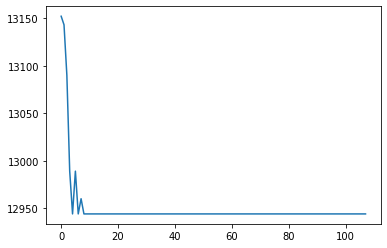

In [16]:
plt.plot(optimizerSA.solutionCallback.costs)

In [17]:
def plot_routes(vehicle_solutions):
    fig, ax = plt.subplots(figsize=(30,30))# add .shp mapfile to axes
    dbf.plot(ax=ax, alpha=0.4,color="grey")

    for vehicle_id in range(len(vehicle_solutions)):
        vehicle_stops_coordinates=points_coordinate[vehicle_solutions[vehicle_id], :]
        ax.plot(vehicle_stops_coordinates[:, 1], vehicle_stops_coordinates[:, 0])
        for i, (x, y) in zip(vehicle_solutions[vehicle_id],zip(vehicle_stops_coordinates[:, 1], vehicle_stops_coordinates[:, 0])):
            ax.text(x, y, str(i), color="red", fontsize=12)

In [18]:
optimizerSA.get_routes()

[[0, 3, 6, 5, 4, 8, 7], [0, 1, 10, 9, 2]]

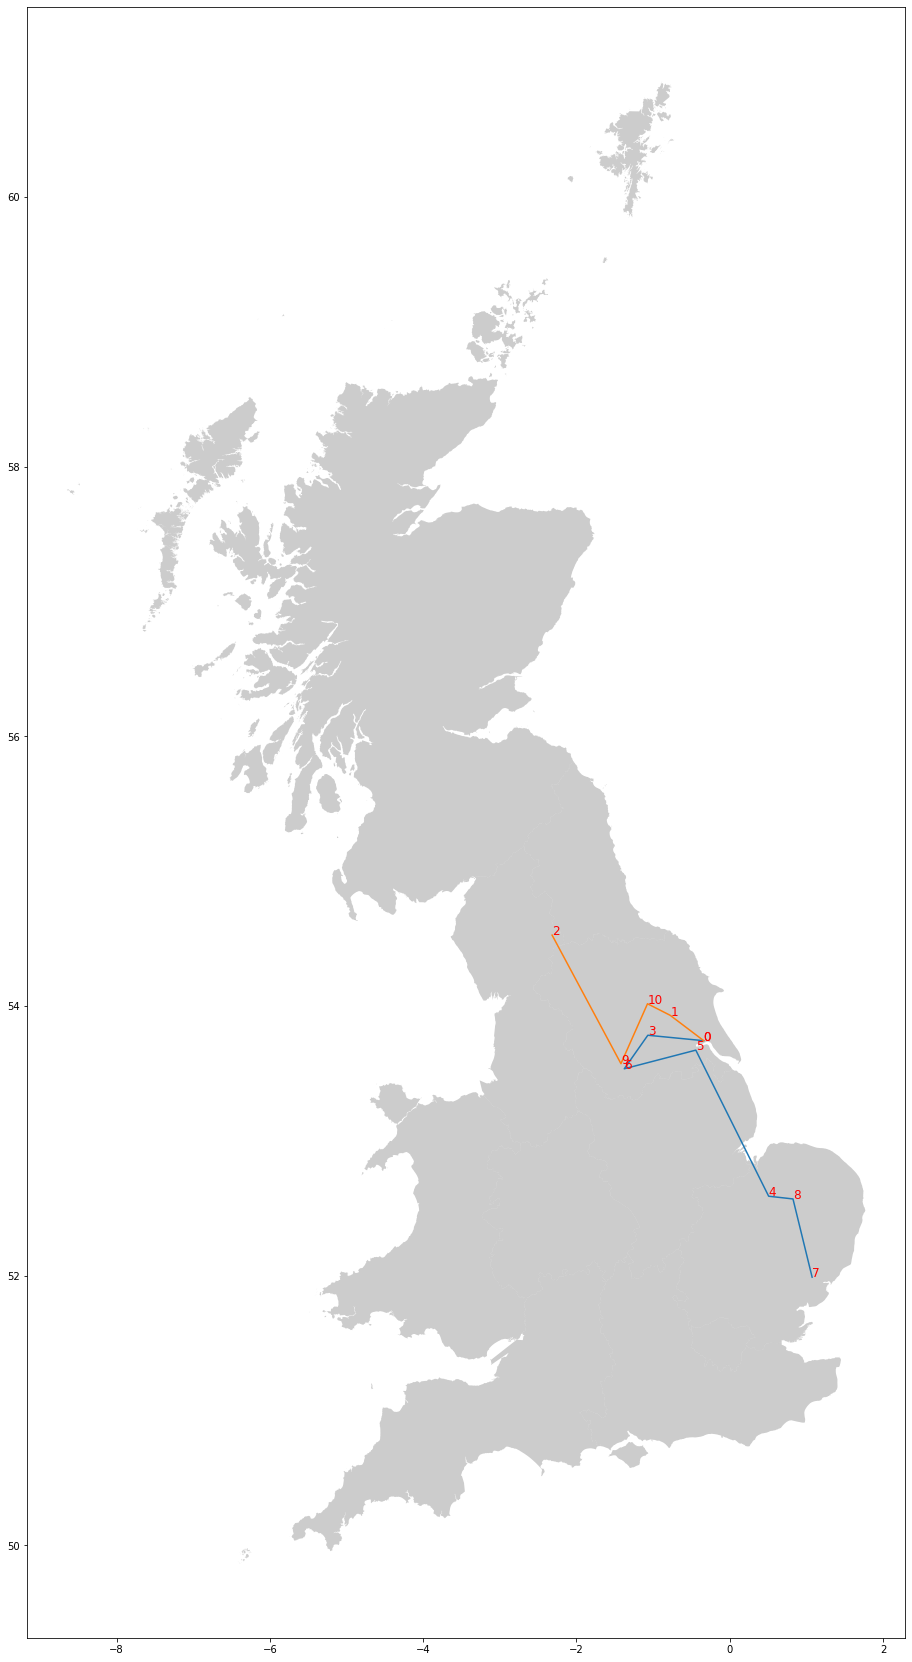

In [19]:
plot_routes(optimizerSA.get_routes())